## Import Libraries

In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
np.random.seed(25)
import os
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

## Read Dataset

In [3]:
train = pd.read_csv('train_foreclosure.csv')
test = pd.read_csv('test_foreclosure.csv')
cust_31JAN = pd.read_excel('Customers_31JAN2019.xlsx')
lms_31JAN = pd.read_excel('LMS_31JAN2019.xlsx')
RF_Final = pd.read_excel('RF_Final_Data.xlsx')

In [4]:
train.head()

,AGREEMENTID,FORECLOSURE
0,11220001,1
1,11220002,1
2,11220006,1
3,11220008,1
4,11220010,1


In [5]:
target = train['FORECLOSURE']

In [15]:
lms_31JAN.head()

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,12001000.0,1.171011e+07,1.171011e+07,2010-08-30,13.734072,10.612692,58.0,120,1,2010-08-29,MUMBAI,7994.273589,7994.273589,0.0,7.516699e+06,7.332154e+06,184544.396568,29042.45880,29042.4588,0.00000,184544.396568,2.262177e+06,9.447930e+06,2.617476e+06,9.338009e+06,2013-11-01,83559.0,40.06,39,19.0,0.0,0.6000,HL,10901100.0,NaN,NaN,39
1,11220002,12001001.0,1.929025e+07,1.929025e+07,2010-09-15,13.734072,10.612692,137.0,180,1,2010-09-15,MUMBAI,100504.575864,100504.575864,0.0,1.061903e+07,1.033958e+07,279448.084560,0.00000,0.0000,0.00000,279448.084560,1.234760e+07,6.942656e+06,4.945154e+06,1.713861e+07,2013-11-01,126530.0,84.31,38,99.0,0.0,0.6000,HL,10901100.0,NaN,NaN,38
2,11220003,12001002.0,4.053499e+06,4.053499e+06,2010-09-06,17.167590,12.485520,360.0,180,5,2010-09-06,MUMBAI,0.000000,0.000000,0.0,2.439242e+06,2.439242e+06,0.000000,0.44171,0.0000,0.44171,-0.441710,3.944954e+06,1.085444e+05,1.549566e+06,3.944954e+06,2013-11-05,30898.0,79.34,38,322.0,0.0,0.9100,HL,10901101.0,NaN,NaN,38
3,11220004,12001003.0,1.325703e+07,1.325703e+07,2010-09-29,15.606900,10.924830,198.0,180,5,2010-09-29,MUMBAI,28441.732656,28441.732656,0.0,7.211965e+06,7.211965e+06,0.000000,0.00000,0.0000,0.00000,0.000000,1.030278e+07,2.954253e+06,4.219464e+06,1.255472e+07,2013-11-05,88256.0,86.86,37,161.0,0.0,0.9686,HL,10901101.0,NaN,NaN,38
4,11220005,12001004.0,1.321140e+07,1.321140e+07,2010-09-06,16.543314,11.861244,142.0,180,5,2010-09-06,MUMBAI,0.000000,0.000000,0.0,7.712034e+06,7.712034e+06,0.000000,0.00000,0.0000,0.00000,0.000000,8.479158e+06,4.732245e+06,3.812974e+06,1.178201e+07,2013-11-05,91892.0,40.93,38,104.0,0.0,0.7300,HL,10901101.0,NaN,NaN,38


In [16]:
lms_31JAN.shape

(624250, 38)

In [17]:
## Sort LMS data based on Last receipt date of transaction

lms_31JAN = lms_31JAN.sort_values(by='LAST_RECEIPT_DATE',ascending=False).drop_duplicates(subset=['AGREEMENTID'])

In [18]:
train_df = pd.merge(train,lms_31JAN,how='inner',on='AGREEMENTID')

In [19]:
test_df = pd.merge(test,lms_31JAN,how='inner',on='AGREEMENTID')

In [20]:
## checking null values
train_df.isnull().sum()

AGREEMENTID                  0
FORECLOSURE                  0
CUSTOMERID                 281
LOAN_AMT                     0
NET_DISBURSED_AMT            0
INTEREST_START_DATE          0
CURRENT_ROI                  0
ORIGNAL_ROI                  0
CURRENT_TENOR                0
ORIGNAL_TENOR                0
DUEDAY                       0
AUTHORIZATIONDATE            0
CITY                         0
PRE_EMI_DUEAMT               0
PRE_EMI_RECEIVED_AMT         0
PRE_EMI_OS_AMOUNT            0
EMI_DUEAMT                   0
EMI_RECEIVED_AMT             0
EMI_OS_AMOUNT                0
EXCESS_AVAILABLE             0
EXCESS_ADJUSTED_AMT          0
BALANCE_EXCESS               0
NET_RECEIVABLE               0
OUTSTANDING_PRINCIPAL        0
PAID_PRINCIPAL               0
PAID_INTEREST                0
MONTHOPENING                 0
LAST_RECEIPT_DATE           75
LAST_RECEIPT_AMOUNT        247
NET_LTV                      0
COMPLETED_TENURE             0
BALANCE_TENURE               0
DPD     

In [21]:
train_df.head()

,AGREEMENTID,FORECLOSURE,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,AUTHORIZATIONDATE,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,1,12001000.0,1.171011e+07,1.171011e+07,2010-08-30,13.421934,10.612692,45.0,120,1,2010-08-29,MUMBAI,7994.273589,7994.273589,0.0,8.614898e+06,8.439420e+06,175477.782641,2.135869e+05,2.135869e+05,0.0,175477.782641,1.164472e+05,1.159366e+07,2.725723e+06,8.693575e+06,2014-05-05,1000000.0,40.06,45,0.0,0.0,0.60,HL,10901100.0,NaN,NaN,45
1,11220002,1,12001001.0,1.929025e+07,1.929025e+07,2010-09-15,13.734072,10.612692,137.0,180,1,2010-09-15,MUMBAI,100504.575864,100504.575864,0.0,1.061903e+07,1.033958e+07,279448.084560,0.000000e+00,0.000000e+00,0.0,279448.084560,1.234760e+07,6.942656e+06,4.945154e+06,1.713861e+07,2013-11-01,126530.0,84.31,38,99.0,0.0,0.60,HL,10901100.0,NaN,NaN,38
2,11220006,1,12001005.0,3.933395e+06,3.933395e+06,2010-11-01,15.606900,11.549106,312.0,180,5,2010-11-02,MUMBAI,5947.630536,5947.630536,0.0,4.670211e+06,4.670211e+06,0.000000,1.179716e+06,1.179716e+06,0.0,0.000000,2.994184e+06,9.392115e+05,2.990124e+06,3.744831e+06,2017-08-05,22878.0,50.89,81,231.0,0.0,0.72,HL,10901101.0,NaN,NaN,81
3,11220008,1,12001007.0,1.002259e+07,1.002259e+07,2010-10-06,11.236968,10.612692,91.0,180,1,2010-10-06,THANE,60322.180776,60322.180776,0.0,1.313098e+07,1.306732e+07,63659.280762,6.770848e+06,6.770848e+06,0.0,63659.280762,4.295120e+04,9.979637e+06,4.648994e+06,5.747875e+06,2018-05-02,65741.0,84.63,91,0.0,0.0,0.60,HL,10901100.0,NaN,NaN,91
4,11220010,1,12001009.0,7.755937e+06,7.755937e+06,2010-10-26,14.982624,10.924830,304.0,180,5,2010-10-26,MUMBAI,27732.787464,27732.787464,0.0,1.048923e+07,1.048923e+07,0.000000,1.202181e+05,1.202181e+05,0.0,0.000000,7.200653e+06,5.552847e+05,6.593778e+06,7.200653e+06,2018-04-05,54433.0,30.94,89,215.0,0.0,0.83,HL,10901101.0,NaN,NaN,90


In [22]:
train_df.dtypes

AGREEMENTID                       int64
FORECLOSURE                       int64
CUSTOMERID                      float64
LOAN_AMT                        float64
NET_DISBURSED_AMT               float64
INTEREST_START_DATE      datetime64[ns]
CURRENT_ROI                     float64
ORIGNAL_ROI                     float64
CURRENT_TENOR                   float64
ORIGNAL_TENOR                     int64
DUEDAY                            int64
AUTHORIZATIONDATE        datetime64[ns]
CITY                             object
PRE_EMI_DUEAMT                  float64
PRE_EMI_RECEIVED_AMT            float64
PRE_EMI_OS_AMOUNT               float64
EMI_DUEAMT                      float64
EMI_RECEIVED_AMT                float64
EMI_OS_AMOUNT                   float64
EXCESS_AVAILABLE                float64
EXCESS_ADJUSTED_AMT             float64
BALANCE_EXCESS                  float64
NET_RECEIVABLE                  float64
OUTSTANDING_PRINCIPAL           float64
PAID_PRINCIPAL                  float64


## Correlation Matrix

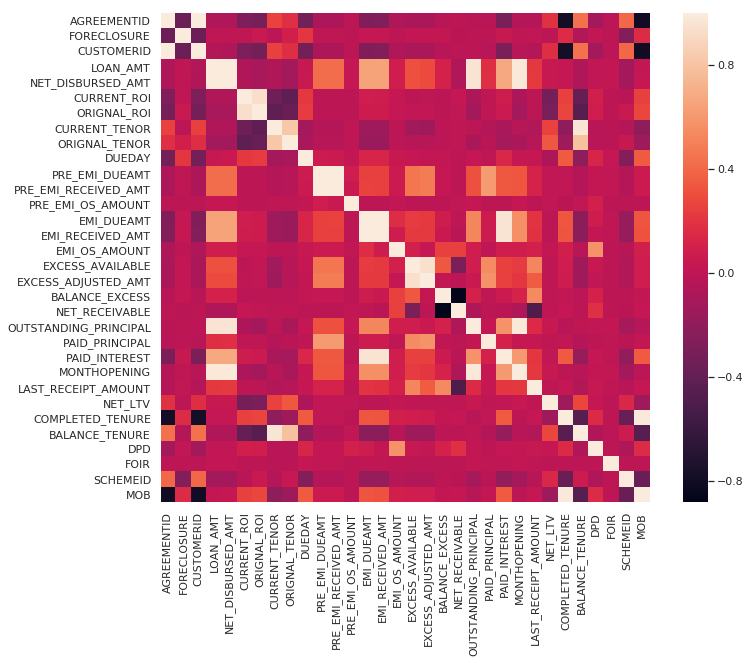

In [23]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

In [24]:
corrmat['FORECLOSURE'].sort_values()

CUSTOMERID              -0.364344
AGREEMENTID             -0.364058
SCHEMEID                -0.255963
BALANCE_TENURE          -0.053532
NET_RECEIVABLE          -0.018133
CURRENT_TENOR           -0.013705
EMI_OS_AMOUNT           -0.003317
PRE_EMI_OS_AMOUNT       -0.002442
FOIR                    -0.002217
OUTSTANDING_PRINCIPAL   -0.001706
NET_LTV                 -0.000437
PAID_PRINCIPAL          -0.000377
LOAN_AMT                 0.002764
NET_DISBURSED_AMT        0.003141
MONTHOPENING             0.003284
CURRENT_ROI              0.004336
PRE_EMI_DUEAMT           0.006460
PRE_EMI_RECEIVED_AMT     0.006543
LAST_RECEIPT_AMOUNT      0.010841
DPD                      0.014886
EXCESS_ADJUSTED_AMT      0.015767
BALANCE_EXCESS           0.016498
EXCESS_AVAILABLE         0.020171
EMI_DUEAMT               0.029229
EMI_RECEIVED_AMT         0.029877
PAID_INTEREST            0.043619
ORIGNAL_ROI              0.048652
ORIGNAL_TENOR            0.089323
COMPLETED_TENURE         0.159146
MOB           

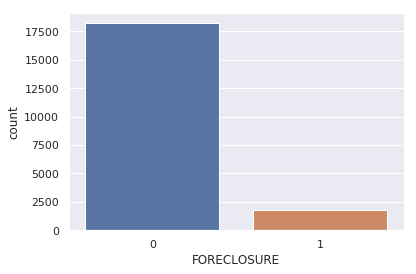

In [25]:
sns.countplot(train_df['FORECLOSURE'])

In [26]:
train_df['CUSTOMERID'].nunique()

19731

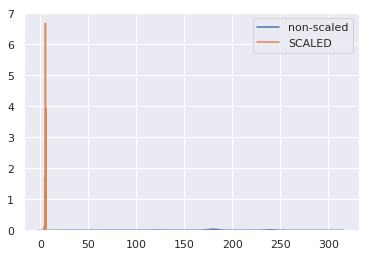

In [27]:
sns.kdeplot(train_df['ORIGNAL_TENOR'],label = 'non-scaled',shade=True)
sns.kdeplot(np.log(train_df['ORIGNAL_TENOR']+1), label='SCALED',shade=True)
plt.legend();

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


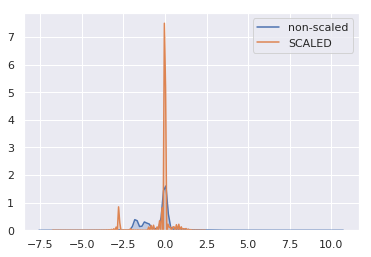

In [28]:
sns.kdeplot(train_df['ORIGNAL_ROI']-train_df['CURRENT_ROI'],label = 'non-scaled',shade=True)
sns.kdeplot(np.log(train_df['ORIGNAL_ROI']-train_df['CURRENT_ROI']+1), label='SCALED',shade=True)
plt.legend();

## Feature Engineering

In [29]:
train_df['diff_LOAN_AMT'] = train_df['LOAN_AMT']-train_df['NET_DISBURSED_AMT']
train_df['diff_tenor'] = train_df['ORIGNAL_TENOR']-train_df['CURRENT_TENOR']
train_df['diff_ROI'] = train_df['ORIGNAL_ROI']-train_df['CURRENT_ROI']
#train_df['total_paid'] = train_df['PAID_PRINCIPAL'] + train_df['PAID_INTEREST']
train_df['total_PRINCIPAL'] = train_df['OUTSTANDING_PRINCIPAL']+train_df['PAID_PRINCIPAL']
train_df['total_tenure'] = train_df['COMPLETED_TENURE']+train_df['BALANCE_TENURE']
train_df['SCHEMEID'].fillna(99999999,inplace=True)
train_df['LAST_RECEIPT_AMOUNT'].fillna(train_df['LAST_RECEIPT_AMOUNT'].mean(),inplace=True)

test_df['diff_tenor'] = test_df['ORIGNAL_TENOR']-test_df['CURRENT_TENOR']
test_df['diff_ROI'] = test_df['ORIGNAL_ROI']-test_df['CURRENT_ROI']
test_df['diff_LOAN_AMT'] = test_df['LOAN_AMT']-test_df['NET_DISBURSED_AMT']
#test_df['total_paid'] = test_df['PAID_PRINCIPAL'] + test_df['PAID_INTEREST']
test_df['total_PRINCIPAL'] = test_df['OUTSTANDING_PRINCIPAL']+test_df['PAID_PRINCIPAL']
test_df['total_tenure'] = test_df['COMPLETED_TENURE']+test_df['BALANCE_TENURE']
test_df['SCHEMEID'].fillna(99999999,inplace=True)
test_df['LAST_RECEIPT_AMOUNT'].fillna(test_df['LAST_RECEIPT_AMOUNT'].mean(),inplace=True)

In [30]:
train_df['SCHEMEID'] = train_df['SCHEMEID'].astype(int)

In [31]:
train_df['Value'] = train_df['LOAN_AMT'] * train_df['NET_LTV']
test_df['Value'] = test_df['LOAN_AMT'] * test_df['NET_LTV']

In [34]:
# Date Features
import datetime as dt
train_df['AUTH_DAY'] = train_df['AUTHORIZATIONDATE'].map(lambda x: x.day)
test_df['AUTH_DAY'] = test_df['AUTHORIZATIONDATE'].map(lambda x: x.day)
train_df['AUTH_MONTH'] = train_df['AUTHORIZATIONDATE'].map(lambda x: x.month)
test_df['AUTH_MONTH'] = test_df['AUTHORIZATIONDATE'].map(lambda x: x.month)
train_df['AUTH_YEAR'] = train_df['AUTHORIZATIONDATE'].map(lambda x: x.year)
test_df['AUTH_YEAR'] = test_df['AUTHORIZATIONDATE'].map(lambda x: x.year)

train_df['INTEREST_DAY'] = train_df['INTEREST_START_DATE'].map(lambda x: x.day)
test_df['INTEREST_DAY'] = test_df['INTEREST_START_DATE'].map(lambda x: x.day)
train_df['INTEREST_MONTH'] = train_df['INTEREST_START_DATE'].map(lambda x: x.month)
test_df['INTEREST_MONTH'] = test_df['INTEREST_START_DATE'].map(lambda x: x.month)
train_df['INTEREST_YEAR'] = train_df['INTEREST_START_DATE'].map(lambda x: x.year)
test_df['INTEREST_YEAR'] = test_df['INTEREST_START_DATE'].map(lambda x: x.year)

train_df['LAST_RECEIPT_DAY'] = train_df['LAST_RECEIPT_DATE'].map(lambda x: x.day)
test_df['LAST_RECEIPT_DAY'] = test_df['LAST_RECEIPT_DATE'].map(lambda x: x.day)
train_df['LAST_RECEIPT_MONTH'] = train_df['LAST_RECEIPT_DATE'].map(lambda x: x.month)
test_df['LAST_RECEIPT_MONTH'] = test_df['LAST_RECEIPT_DATE'].map(lambda x: x.month)
train_df['LAST_RECEIPT_YEAR'] = train_df['LAST_RECEIPT_DATE'].map(lambda x: x.year)
test_df['LAST_RECEIPT_YEAR'] = test_df['LAST_RECEIPT_DATE'].map(lambda x: x.year)

In [35]:
train_df.isnull().sum()

AGREEMENTID                  0
FORECLOSURE                  0
CUSTOMERID                 281
LOAN_AMT                     0
NET_DISBURSED_AMT            0
INTEREST_START_DATE          0
CURRENT_ROI                  0
ORIGNAL_ROI                  0
CURRENT_TENOR                0
ORIGNAL_TENOR                0
DUEDAY                       0
AUTHORIZATIONDATE            0
CITY                         0
PRE_EMI_DUEAMT               0
PRE_EMI_RECEIVED_AMT         0
PRE_EMI_OS_AMOUNT            0
EMI_DUEAMT                   0
EMI_RECEIVED_AMT             0
EMI_OS_AMOUNT                0
EXCESS_AVAILABLE             0
EXCESS_ADJUSTED_AMT          0
BALANCE_EXCESS               0
NET_RECEIVABLE               0
OUTSTANDING_PRINCIPAL        0
PAID_PRINCIPAL               0
PAID_INTEREST                0
MONTHOPENING                 0
LAST_RECEIPT_DATE           75
LAST_RECEIPT_AMOUNT          0
NET_LTV                      0
COMPLETED_TENURE             0
BALANCE_TENURE               0
DPD     

## Handling Null Values

In [36]:
train_df['LAST_RECEIPT_DAY'].fillna(train_df['LAST_RECEIPT_DAY'].mode()[0],inplace=True)
train_df['LAST_RECEIPT_MONTH'].fillna(train_df['LAST_RECEIPT_MONTH'].mode()[0],inplace=True)
train_df['LAST_RECEIPT_YEAR'].fillna(train_df['LAST_RECEIPT_YEAR'].mode()[0],inplace=True)

test_df['LAST_RECEIPT_DAY'].fillna(test_df['LAST_RECEIPT_DAY'].mode()[0],inplace=True)
test_df['LAST_RECEIPT_MONTH'].fillna(test_df['LAST_RECEIPT_MONTH'].mode()[0],inplace=True)
test_df['LAST_RECEIPT_YEAR'].fillna(test_df['LAST_RECEIPT_YEAR'].mode()[0],inplace=True)

In [37]:
train_df.dtypes

AGREEMENTID                       int64
FORECLOSURE                       int64
CUSTOMERID                      float64
LOAN_AMT                        float64
NET_DISBURSED_AMT               float64
INTEREST_START_DATE      datetime64[ns]
CURRENT_ROI                     float64
ORIGNAL_ROI                     float64
CURRENT_TENOR                   float64
ORIGNAL_TENOR                     int64
DUEDAY                            int64
AUTHORIZATIONDATE        datetime64[ns]
CITY                             object
PRE_EMI_DUEAMT                  float64
PRE_EMI_RECEIVED_AMT            float64
PRE_EMI_OS_AMOUNT               float64
EMI_DUEAMT                      float64
EMI_RECEIVED_AMT                float64
EMI_OS_AMOUNT                   float64
EXCESS_AVAILABLE                float64
EXCESS_ADJUSTED_AMT             float64
BALANCE_EXCESS                  float64
NET_RECEIVABLE                  float64
OUTSTANDING_PRINCIPAL           float64
PAID_PRINCIPAL                  float64


In [38]:
train_df['AUTH_YEAR'].value_counts()

2018    7568
2017    4896
2016    2545
2015    1771
2014    1403
2013     906
2012     635
2011     269
2010      19
Name: AUTH_YEAR, dtype: int64

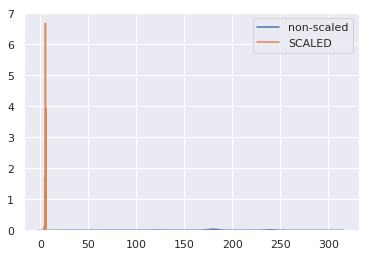

In [39]:
sns.kdeplot(train_df['ORIGNAL_TENOR'],label = 'non-scaled',shade=True)
sns.kdeplot(np.log(train_df['ORIGNAL_TENOR']+1), label='SCALED',shade=True)
plt.legend();

## Feature Transformation

In [40]:
for i in train_df.columns:
    if train_df[i].dtype == 'float64':
        train_df[i] = np.log(train_df[i]+1)
        test_df[i] = np.log(test_df[i]+1)
        
train_df['DUEDAY'] = np.log(train_df['DUEDAY']+1)
test_df['DUEDAY'] = np.log(test_df['DUEDAY']+1)

train_df['ORIGNAL_TENOR'] = np.log(train_df['ORIGNAL_TENOR']+1)
test_df['ORIGNAL_TENOR'] = np.log(test_df['ORIGNAL_TENOR']+1)

train_df['COMPLETED_TENURE'] = np.log(train_df['COMPLETED_TENURE']+1)
test_df['COMPLETED_TENURE'] = np.log(test_df['COMPLETED_TENURE']+1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


## Lable Encoding for Categorical Features

In [41]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
train_df["CITY"] = lb_make.fit_transform(train_df["CITY"])
train_df["PRODUCT"] = lb_make.fit_transform(train_df["PRODUCT"])

test_df["CITY"] = lb_make.fit_transform(test_df["CITY"])
test_df["PRODUCT"] = lb_make.fit_transform(test_df["PRODUCT"])

In [42]:
## features to be included in the model
feature_names = [x for x in train_df.columns if x not in ['AGREEMENTID','FORECLOSURE','NPA_IN_LAST_MONTH','NPA_IN_CURRENT_MONTH'
                                                      ,'LAST_RECEIPT_DATE','CUSTOMERID',
                                                         'INTEREST_START_DATE','AUTHORIZATIONDATE']]

## Modeling

In [43]:
model = CatBoostClassifier(iterations=5000,eval_metric='AUC',random_seed=42,verbose=False,max_depth=13,learning_rate=0.05,task_type='GPU')
model.fit(train_df[feature_names],target)
pred = model.predict_proba(test_df[feature_names])

In [52]:
## make submission
sub = pd.DataFrame()
sub['AGREEMENTID'] = test['AGREEMENTID']
sub['FORECLOSURE'] = [i[1] for i in pred]
sub.to_csv('result.csv', index=False)

In [53]:
sub.head()

,AGREEMENTID,FORECLOSURE
0,11220003,0.997010
1,11220004,0.999709
2,11220005,0.999951
3,11220007,0.999589
4,11220009,0.000752
